In [140]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv


In [160]:
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns

import warnings, os, gc, sys, math, json, random, itertools

from scipy import stats
from scipy.stats import ks_2samp

# Pretty settings
warnings.filterwarnings("ignore")
plt.style.use("seaborn-whitegrid")
sns.set_palette("crest")
pd.set_option("display.max_columns", 100)

In [142]:
train=pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')
test=pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')

In [143]:
train.head(5)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [144]:
test.head(5)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,18524,3.0,No,7.0,4.0,No,6.0,NaN
1,18525,NaN,Yes,0.0,0.0,Yes,5.0,1.0
2,18526,3.0,No,5.0,6.0,No,15.0,9.0
3,18527,3.0,No,4.0,4.0,No,5.0,6.0
4,18528,9.0,Yes,1.0,2.0,Yes,1.0,1.0


# Exploratory Data Analysis

# Information

In [145]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB


In [146]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6175 entries, 0 to 6174
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         6175 non-null   int64  
 1   Time_spent_Alone           5750 non-null   float64
 2   Stage_fear                 5577 non-null   object 
 3   Social_event_attendance    5778 non-null   float64
 4   Going_outside              5709 non-null   float64
 5   Drained_after_socializing  5743 non-null   object 
 6   Friends_circle_size        5825 non-null   float64
 7   Post_frequency             5767 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 386.1+ KB


In [147]:
train.shape

(18524, 9)

In [148]:
train.isnull().sum()

id                              0
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64

In [149]:
test.isnull().sum()

id                             0
Time_spent_Alone             425
Stage_fear                   598
Social_event_attendance      397
Going_outside                466
Drained_after_socializing    432
Friends_circle_size          350
Post_frequency               408
dtype: int64

In [151]:
print("Descriptive statistics for numerical columns in train_df:")
display(train.describe())

print("\nDescriptive statistics for categorical columns in train_df:")
display(train.describe(include='object'))

print("\nDescriptive statistics for numerical columns in test_df:")
display(test.describe())

print("\nDescriptive statistics for categorical columns in test_df:")
display(test.describe(include='object'))

Descriptive statistics for numerical columns in train_df:


,id,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,18524.000000,17334.000000,17344.000000,17058.000000,17470.000000,17260.000000
mean,9261.500000,3.137764,5.265106,4.044319,7.996737,4.982097
std,5347.562529,3.003786,2.753359,2.062580,4.223484,2.879139
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4630.750000,1.000000,3.000000,3.000000,5.000000,3.000000
50%,9261.500000,2.000000,5.000000,4.000000,8.000000,5.000000
75%,13892.250000,4.000000,8.000000,6.000000,12.000000,7.000000
max,18523.000000,11.000000,10.000000,7.000000,15.000000,10.000000



Descriptive statistics for categorical columns in train_df:


,Stage_fear,Drained_after_socializing,Personality
count,16631,17375,18524
unique,2,2,2
top,No,No,Extrovert
freq,12609,13313,13699



Descriptive statistics for numerical columns in test_df:


,id,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,6175.000000,5750.000000,5778.000000,5709.000000,5825.000000,5767.000000
mean,21611.000000,3.116870,5.287989,4.037835,8.008412,5.028958
std,1782.713288,2.985658,2.758052,2.045207,4.192701,2.867285
min,18524.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20067.500000,1.000000,3.000000,3.000000,5.000000,3.000000
50%,21611.000000,2.000000,5.000000,4.000000,8.000000,5.000000
75%,23154.500000,4.000000,8.000000,6.000000,12.000000,7.000000
max,24698.000000,11.000000,10.000000,7.000000,15.000000,10.000000



Descriptive statistics for categorical columns in test_df:


,Stage_fear,Drained_after_socializing
count,5577,5743
unique,2,2
top,No,No
freq,4236,4437


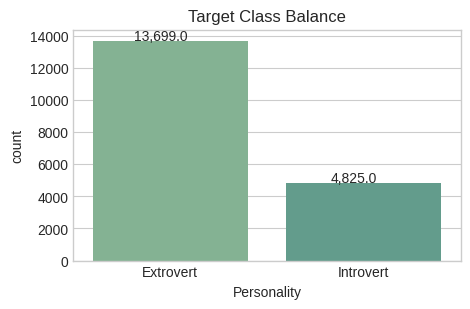

Personality
Extrovert    0.739527
Introvert    0.260473
Name: proportion, dtype: float64


In [167]:
fig, ax = plt.subplots(figsize=(5,3))
sns.countplot(data=train, x="Personality", ax=ax)
ax.set_title("Target Class Balance")
for p in ax.patches:
    ax.annotate(f"{p.get_height():,}", (p.get_x()+.35, p.get_height()+50), ha="center")
plt.show()

print(train["Personality"].value_counts(normalize=True).rename("proportion"))

# Univariate analysis

# Numerical features

**Train data**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


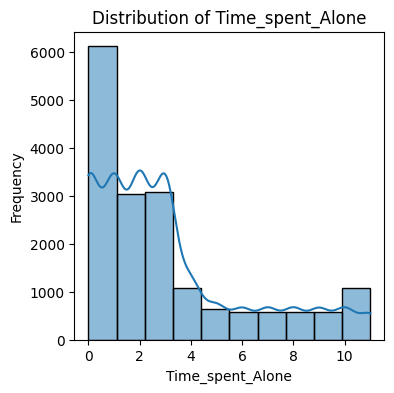

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


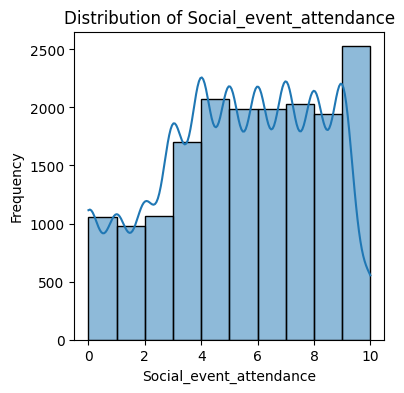

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


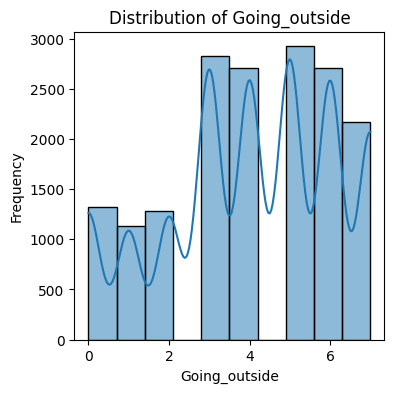

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


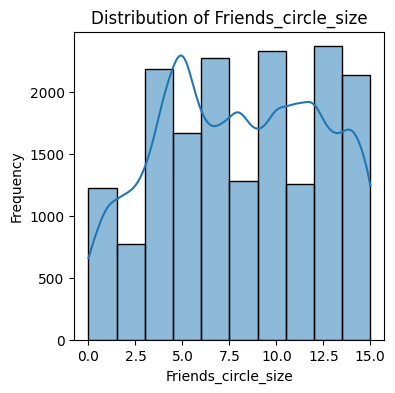

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


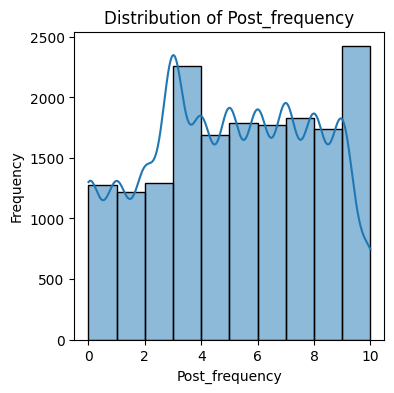

In [92]:
numerical_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 
                   'Friends_circle_size', 'Post_frequency']

for col in numerical_cols:
    plt.figure(figsize=(4,4))
    sns.histplot(train[col], kde=True, bins=10)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [93]:
train[numerical_cols] = train[numerical_cols].apply(pd.to_numeric, errors='coerce')


1.133777036719707
-0.22923760229450502
-0.36722086539805504
-0.051806107204632273
-0.0587064407734749


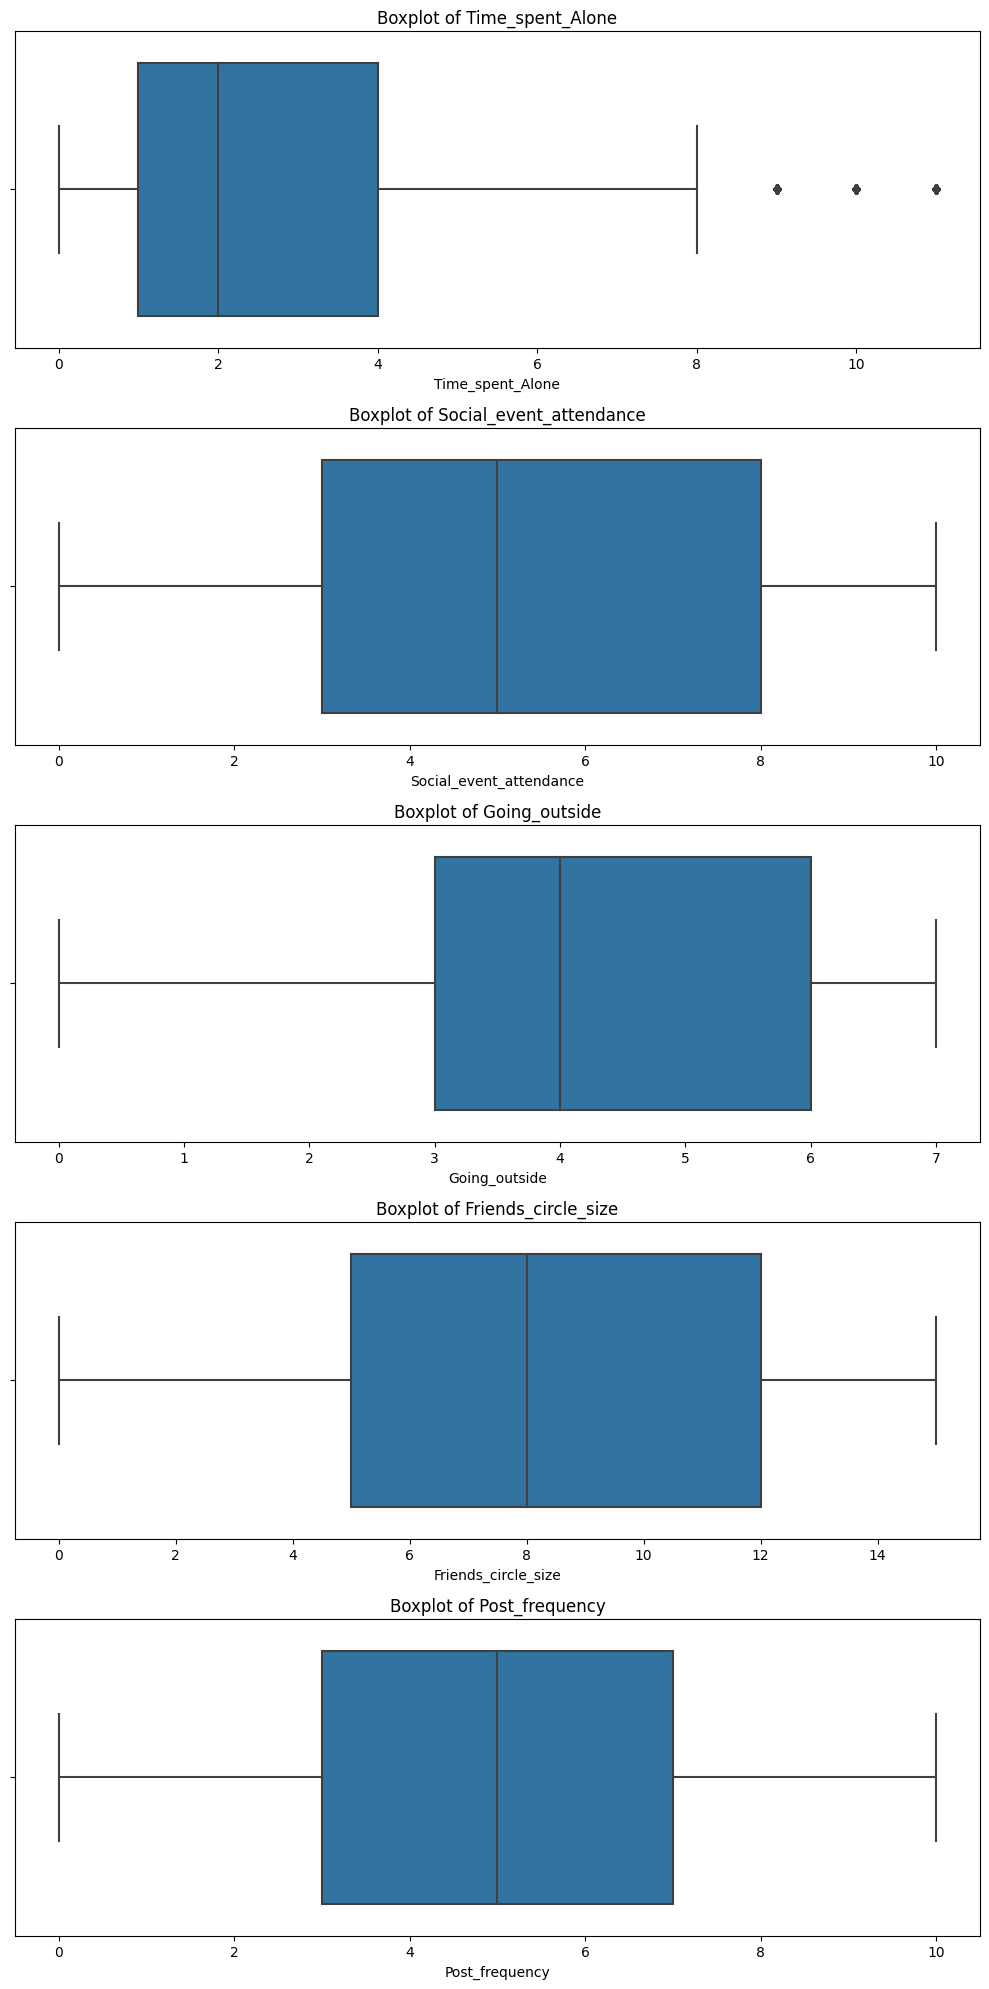

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
fig, axes = plt.subplots(nrows=len(numerical_cols), figsize=(10, 20))

for i, col in enumerate(numerical_cols):
    sns.boxplot(x=train[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    print(train[col].skew())

plt.tight_layout()
plt.show()


**Test data**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


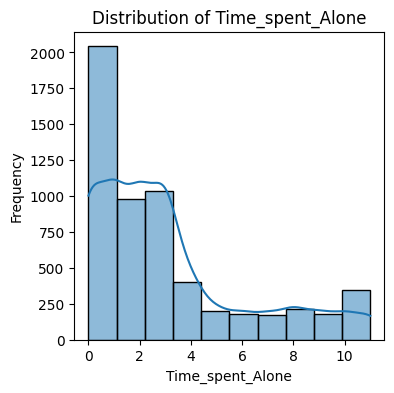

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


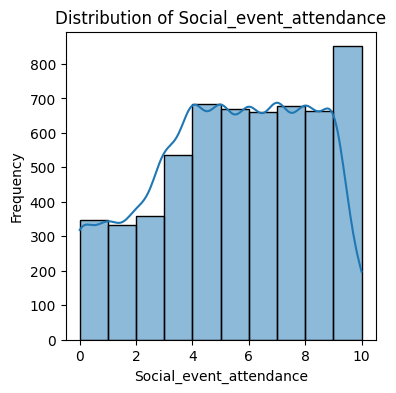

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


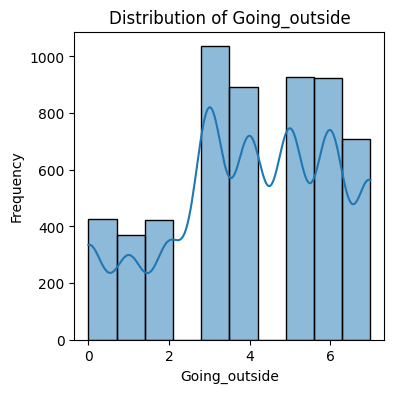

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


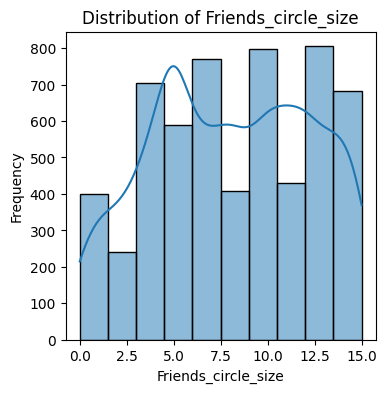

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


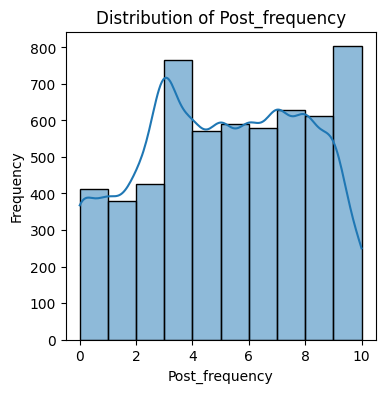

In [113]:
numerical_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 
                   'Friends_circle_size', 'Post_frequency']

for col in numerical_cols:
    plt.figure(figsize=(4,4))
    sns.histplot(test[col], kde=True, bins=10)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

1.1534763251487632
-0.24436140090065894
-0.3453593158723529
-0.06498469447098446
-0.07496136259306817


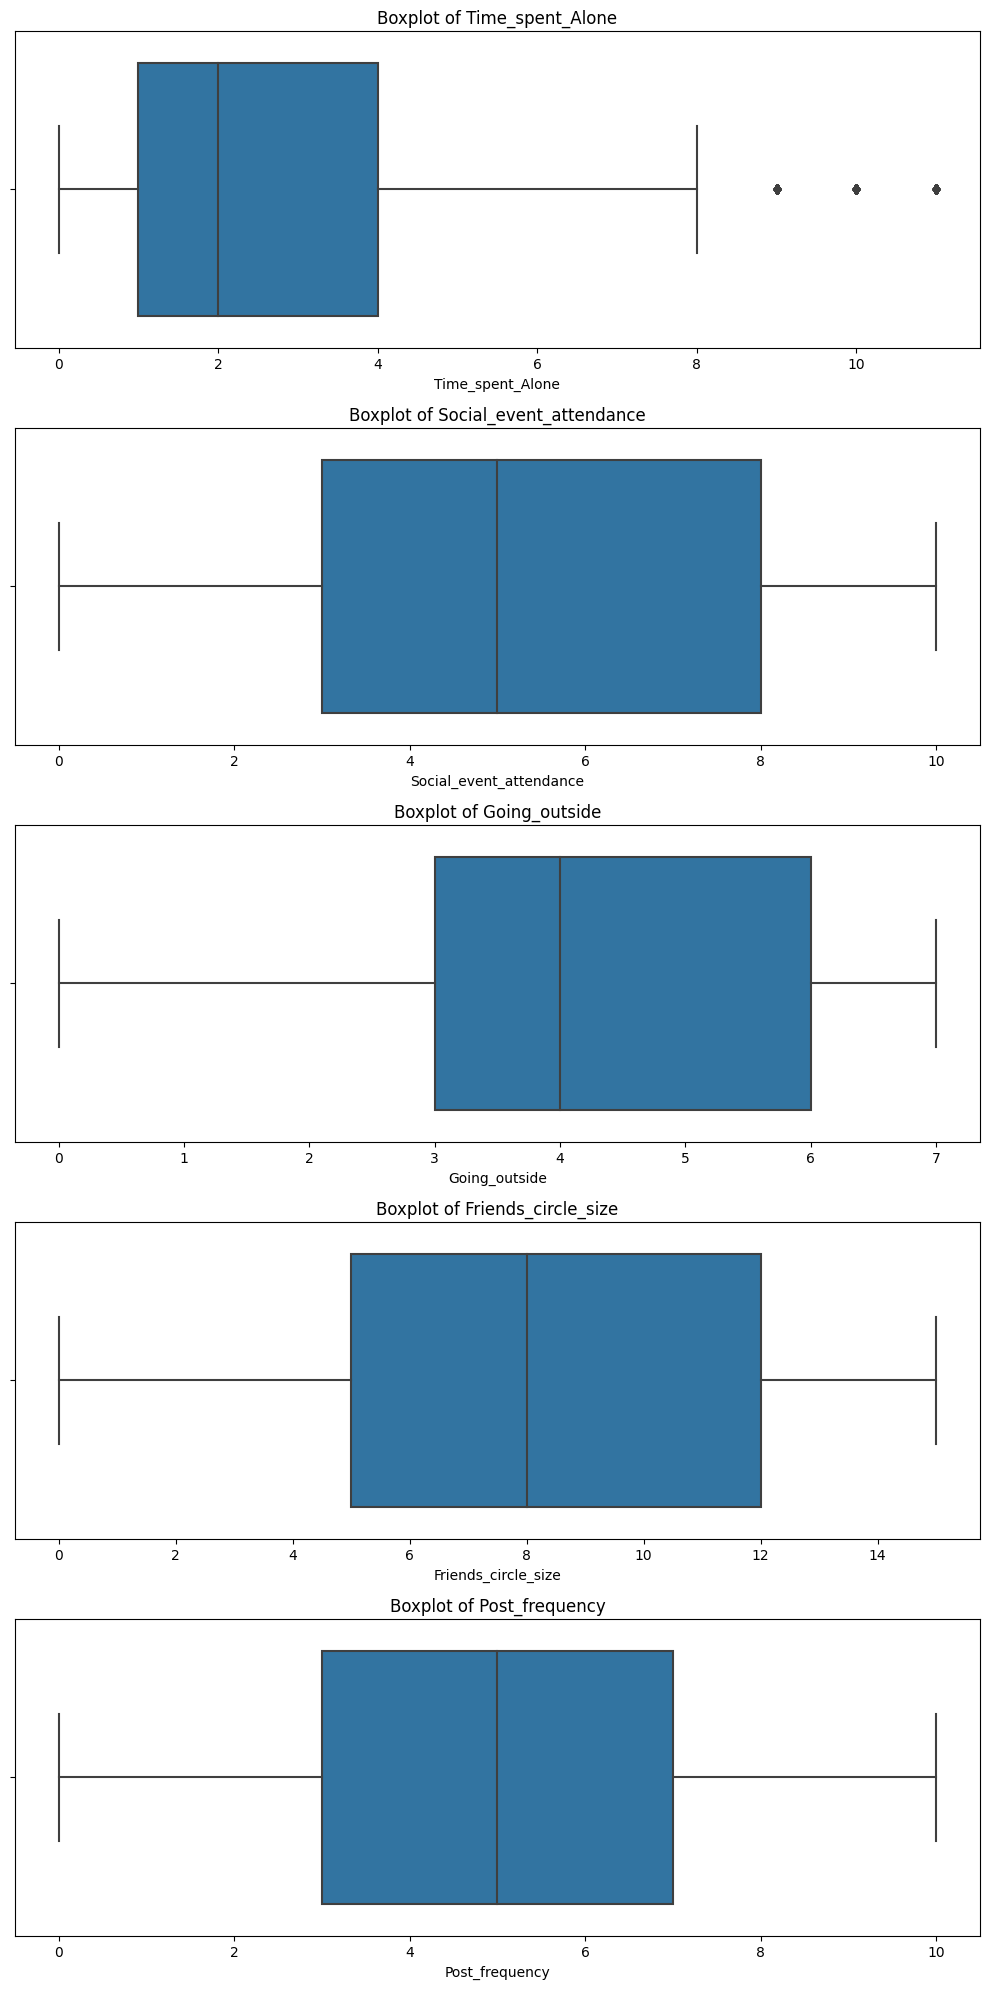

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
fig, axes = plt.subplots(nrows=len(numerical_cols), figsize=(10, 20))

for i, col in enumerate(numerical_cols):
    sns.boxplot(x=test[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    print(test[col].skew())

plt.tight_layout()
plt.show()


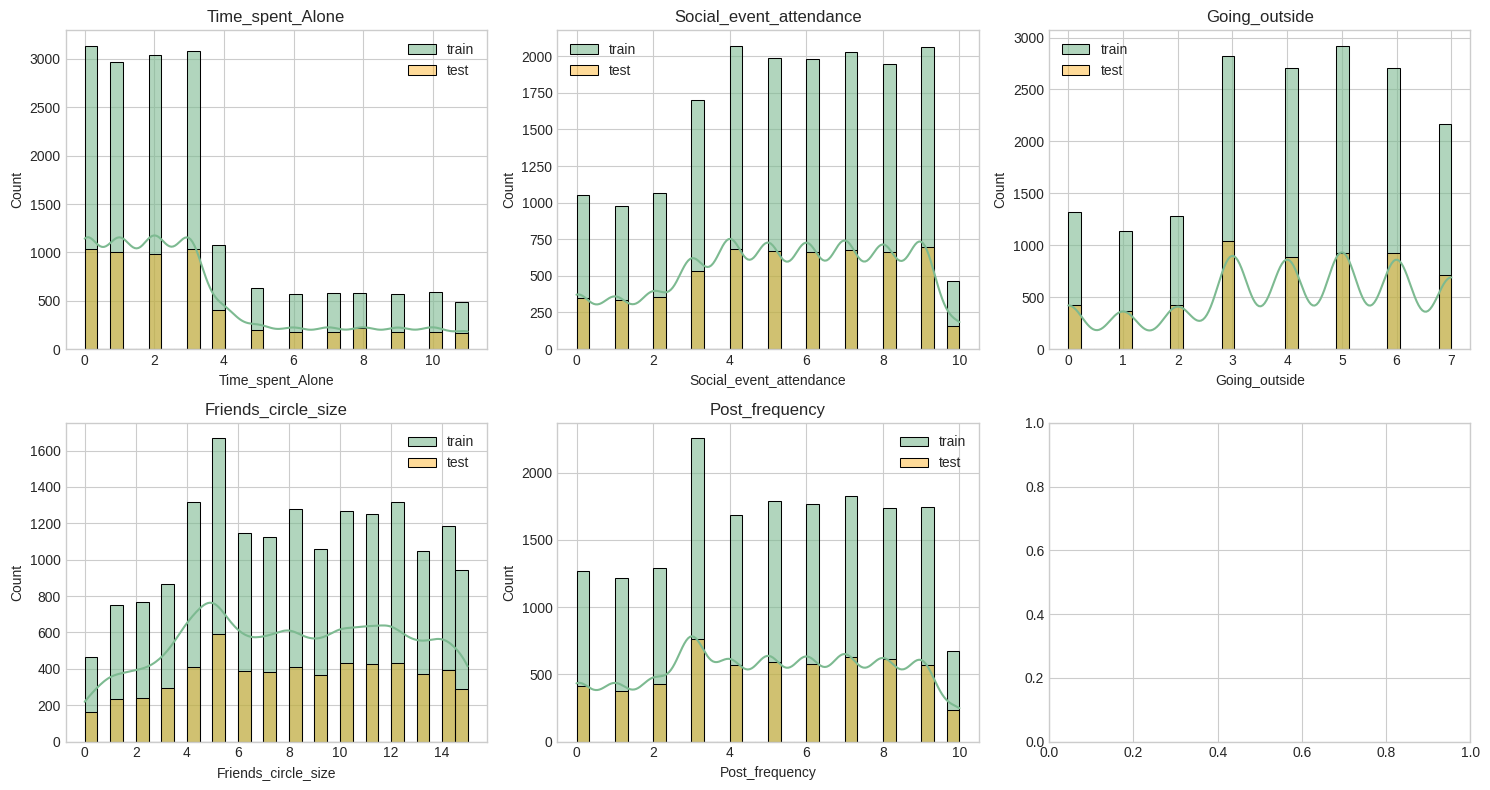

In [168]:
num_cols = train.select_dtypes("number").columns.drop(["id"])  # exclude id
fig, axes = plt.subplots(math.ceil(len(num_cols)/3), 3, figsize=(15,4*math.ceil(len(num_cols)/3)))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(train[col], kde=True, ax=axes[i], bins=30, alpha=.6, label="train")
    sns.histplot(test[col],  kde=False, ax=axes[i], bins=30, color="orange", alpha=.4, label="test")
    axes[i].set_title(col)
    axes[i].legend()
plt.tight_layout()
plt.show()

In [163]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rakeshkapilavai/extrovert-vs-introvert-behavior-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/extrovert-vs-introvert-behavior-data


In [164]:
original_0 = pd.read_csv("/kaggle/input/extrovert-vs-introvert-behavior-data/personality_datasert.csv")
original_1  = pd.read_csv("/kaggle/input/extrovert-vs-introvert-behavior-data/personality_dataset.csv")
original = pd.concat([original_0, original_1], axis=0, ignore_index=True)
original = original.drop_duplicates().reset_index(drop=True)

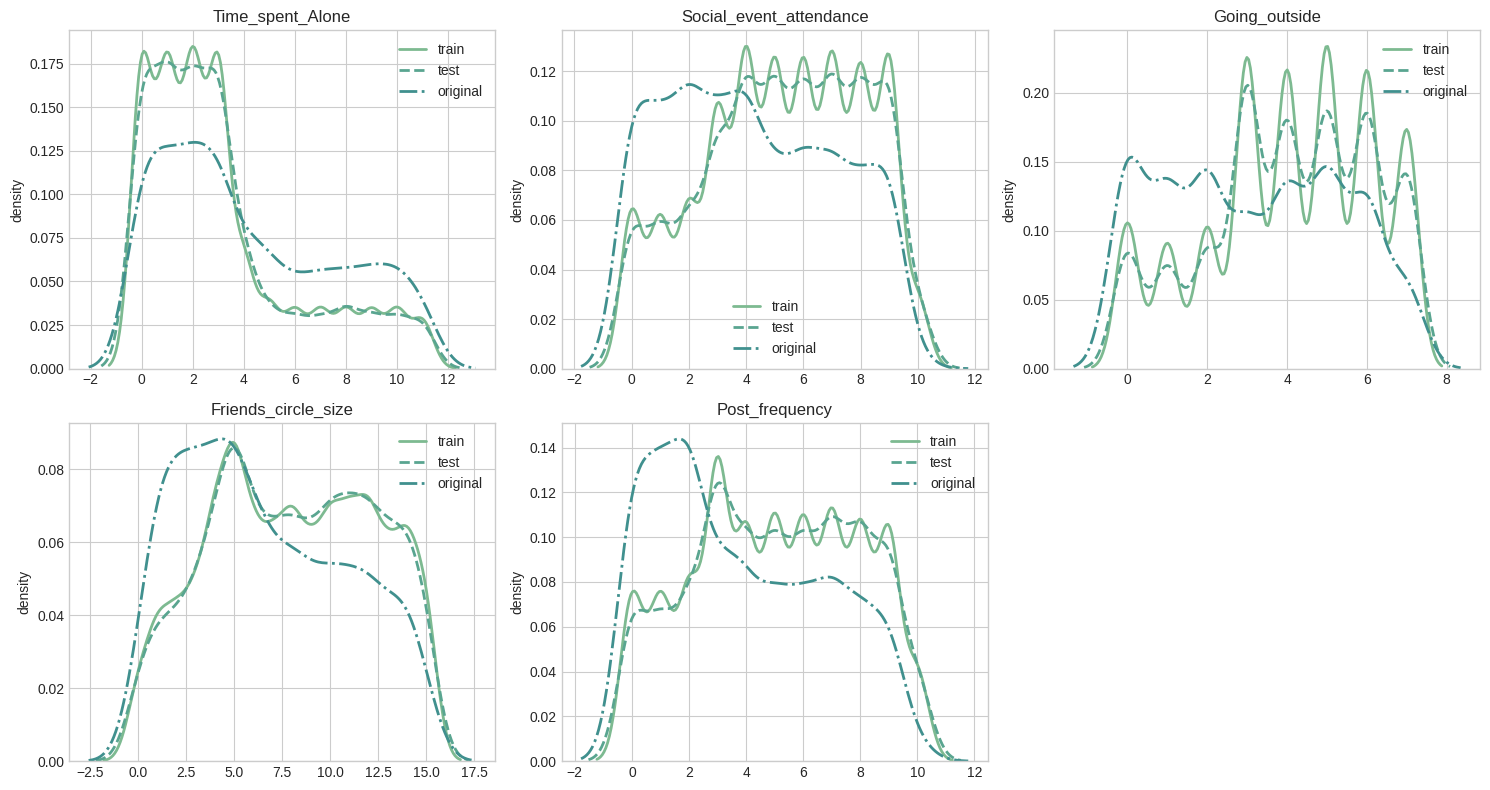

In [165]:
import math
num_cols = train.select_dtypes(np.number).columns.drop("id")        # adjust if 'id' has a different dtype
cols_per_row = 3
rows = math.ceil(len(num_cols) / cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, 4 * rows))
axes = axes.flatten()

for ax, col in zip(axes, num_cols):
    sns.kdeplot(train[col].dropna(), ax=ax, label="train", linewidth=2)
    sns.kdeplot(test[col].dropna(),  ax=ax, label="test" , linewidth=2, linestyle="--")
    sns.kdeplot(original[col].dropna(),  ax=ax, label="original" , linewidth=2, linestyle="-.")
    ax.set_title(col)
    ax.set_xlabel("")
    ax.set_ylabel("density")
    ax.legend()

# tidy extra axes (if any)
for j in range(len(num_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Categorical Variables

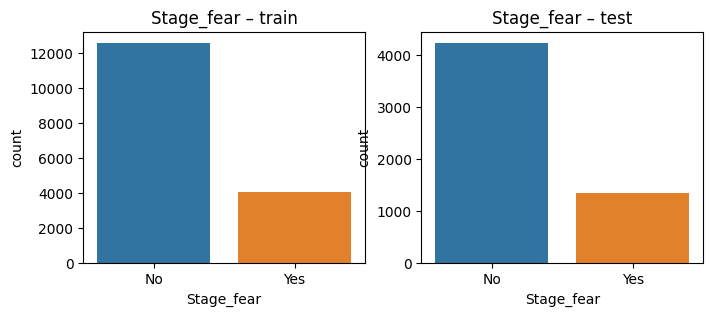

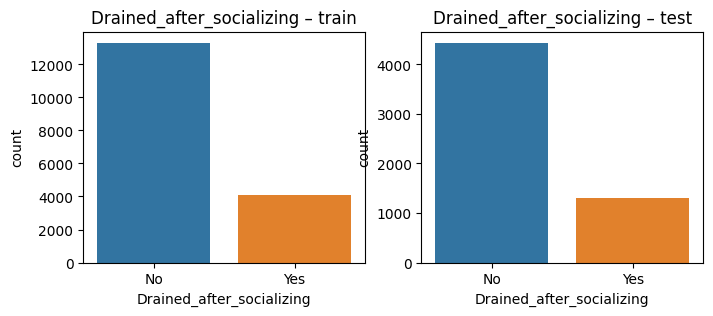

In [157]:
cat_cols = ["Stage_fear", "Drained_after_socializing"]
for col in cat_cols:
    fig, ax = plt.subplots(1,2, figsize=(8,3))
    sns.countplot(x=col, data=train, ax=ax[0])
    ax[0].set_title(f"{col} – train")
    sns.countplot(x=col, data=test,  ax=ax[1])
    ax[1].set_title(f"{col} – test")
    plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

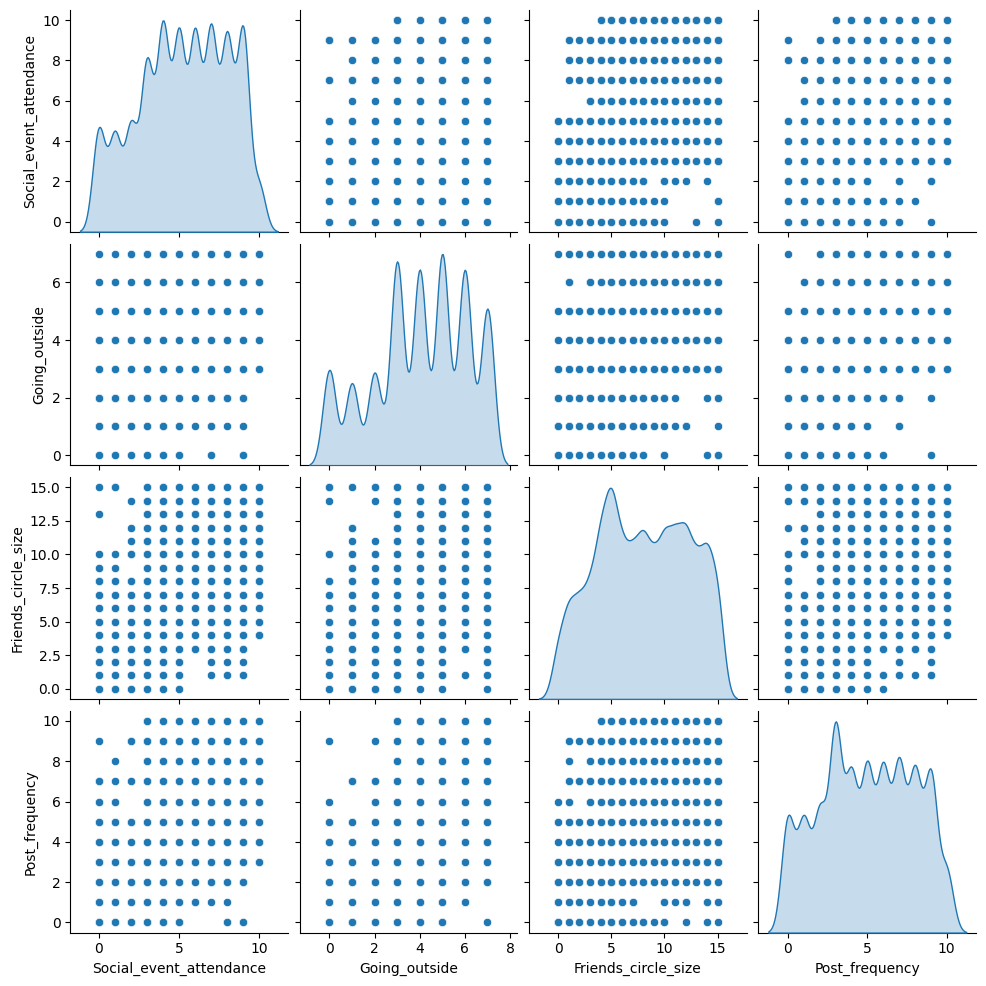

In [152]:
sns.pairplot(train, vars=['Social_event_attendance','Going_outside', 
                   'Friends_circle_size','Post_frequency'],diag_kind='kde')

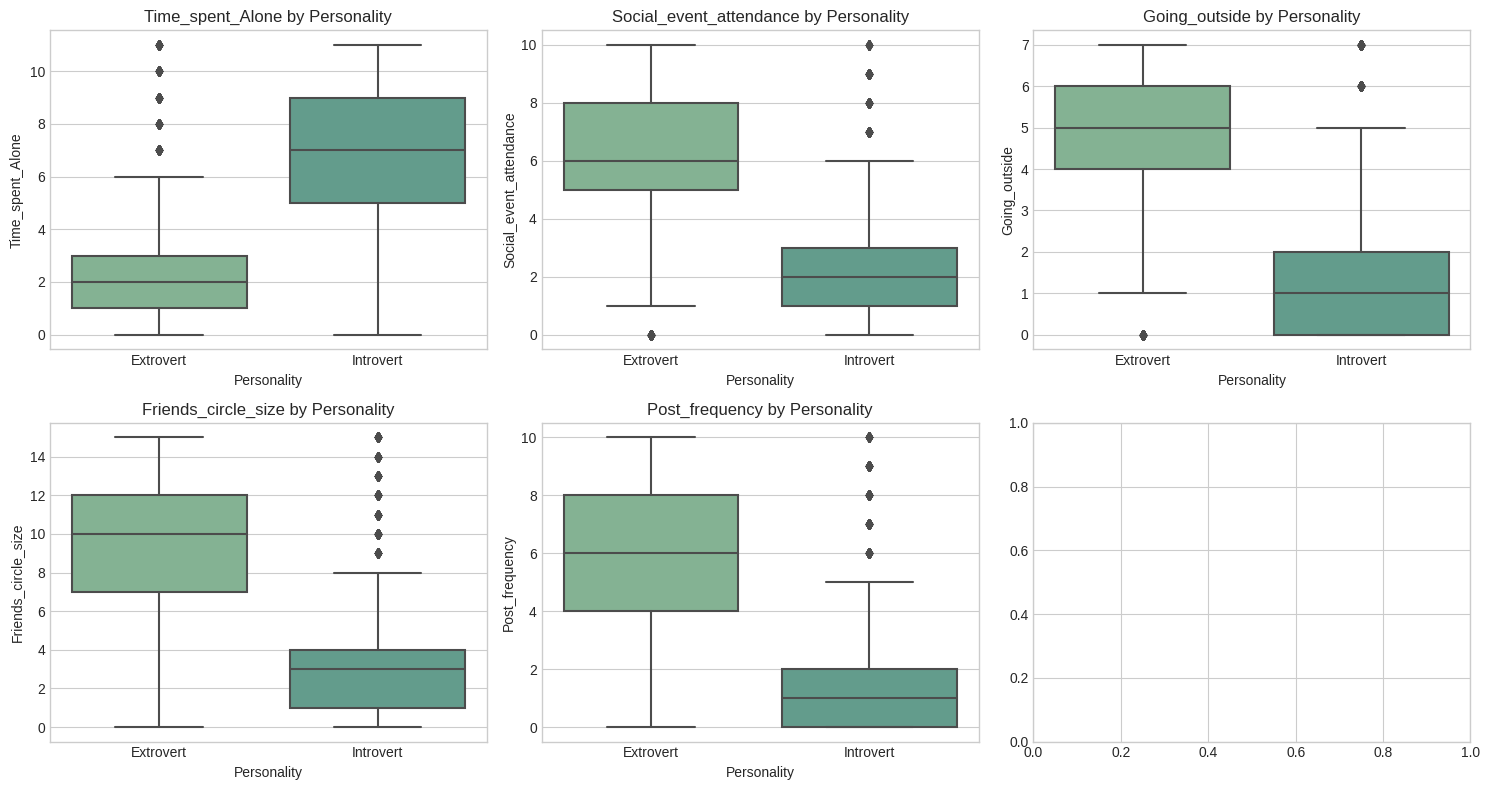

In [166]:
# Numeric vs target
fig, axes = plt.subplots(math.ceil(len(num_cols)/3), 3, figsize=(15,4*math.ceil(len(num_cols)/3)))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x="Personality", y=col, data=train, ax=axes[i])
    axes[i].set_title(f"{col} by Personality")
plt.tight_layout()
plt.show()

In [169]:
# Categorical vs target
for col in cat_cols:
    ct = pd.crosstab(train[col], train["Personality"], normalize="index")*100
    sns.
    display(ct.style.format("{:.1f}%").set_caption(f"{col} ↔ Personality"))

Personality,Extrovert,Introvert
Stage_fear,,
No,97.7%,2.3%
Yes,5.9%,94.1%


Personality,Extrovert,Introvert
Drained_after_socializing,,
No,97.7%,2.3%
Yes,5.8%,94.2%


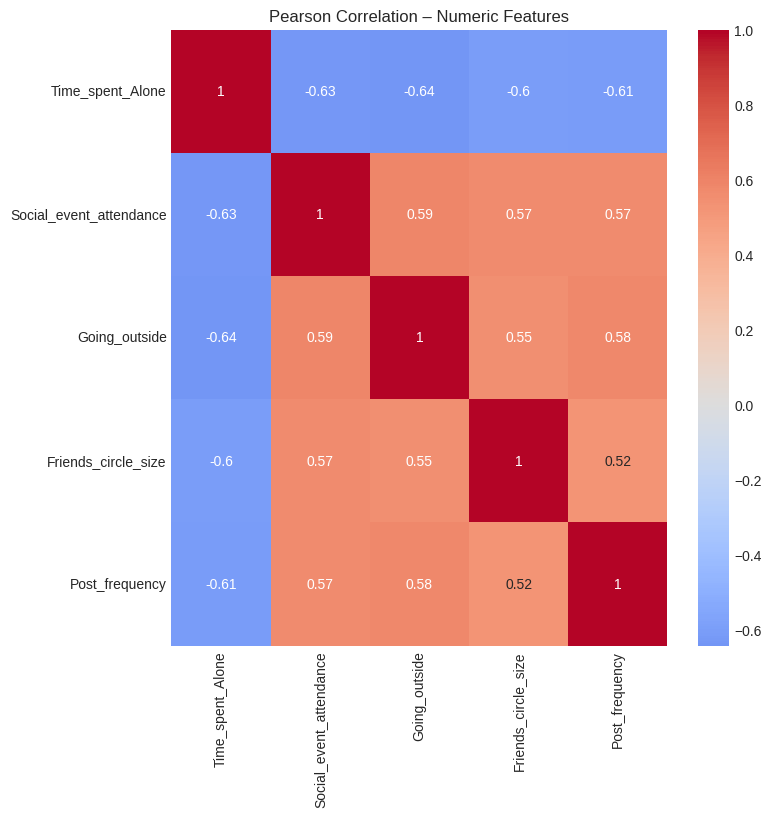

In [171]:
corr = train[num_cols].corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Pearson Correlation – Numeric Features")
plt.show()

In [179]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train['Personality_encoded'] = le.fit_transform(train['Personality'])


In [180]:
correlation_with_target = train.corr(numeric_only=True)['Personality_encoded'].sort_values(ascending=False)
print(correlation_with_target)

Personality_encoded        1.000000
Time_spent_Alone           0.776725
id                         0.001475
Friends_circle_size       -0.657216
Post_frequency            -0.678355
Social_event_attendance   -0.702879
Going_outside             -0.708869
Name: Personality_encoded, dtype: float64


In [176]:
print(train.columns)

Index(['id', 'Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
       'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
       'Post_frequency', 'Personality'],
      dtype='object')


#

# Imputation

In [95]:
train['Time_spent_Alone']=train['Time_spent_Alone'].fillna(train['Time_spent_Alone'].median())

In [117]:
test['Time_spent_Alone'] = test['Time_spent_Alone'].fillna(test['Time_spent_Alone'].median())

In [96]:
mean_impute = ['Social_event_attendance','Going_outside', 
                   'Friends_circle_size','Post_frequency']

In [97]:
for col in mean_impute:
    train[col]=train[col].fillna(train[col].mean())

In [99]:
train.isnull().sum()

id                              0
Time_spent_Alone                0
Stage_fear                   1893
Social_event_attendance         0
Going_outside                   0
Drained_after_socializing    1149
Friends_circle_size             0
Post_frequency                  0
Personality                     0
dtype: int64